# Image & Image Sequence Processing
## Tracking in microscopy


### Santiago Quinteros

# Loading of python libraries

In [1]:
!pip install numpy
!pip install -U scikit-image
!pip install ipywidgets
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Definition of classes and functions

In [2]:
import math
from skimage.draw import circle_perimeter

class Spot:
    def __init__(self, x, y, t, value, matched=None, daughterOf=None):
        self.x = x # int: position x --> column 
        self.y = y # int: position y --> raw
        self.t = t # int: position t
        self.value = value # float: intensity value at Im(x, y, t)
        self.matched = matched # Spot: linked detection in the frame t+1
    
    def distance(self, spot): # Spot spot
        dist=math.sqrt((self.x-spot.x)**2+(self.y-spot.y)**2)# Euclidean distance
        return dist
    
    def draw(self, size, stack_results): 
        # stack_results: image in which we draw the detections and the trajectories. Shape (T,W,L,C)
        # size: radius of the circle
        rr, cc = circle_perimeter(self.y, self.x, size, shape=(stack_results.shape[1], stack_results.shape[2]))
        stack_results[self.t,rr, cc, :] = (255, 0, 0)

In [3]:
from skimage.draw import line
import numpy as np

class Trajectory:
    def __init__(self): 
        self.list_spots = [] # a trajectory is a list of spots
    
    def add(self, spot): 
        self.list_spots.append(spot) # a trajectory is a list of spots
        
    def last_spot(self): # return the last spot added to the trajectory
        return self.list_spots[-1]
    
    def draw(self, stack_results):
        color = list(np.random.choice(range(256), size=3))
        nbSpots = len(self.list_spots)
        for i in range(nbSpots-1):
            spot1 = self.list_spots[i]
            spot2 = self.list_spots[i+1]
            rr, cc = line(spot1.y, spot1.x, spot2.y, spot2.x)
            stack_results[:, rr, cc, :] = color

In [4]:
import matplotlib.pyplot as plt

def plot_image(image, title):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def plot_image_RGB(image, title):
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def plot_stack(image, index, title):
    plt.imshow(image[index], cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def plot_trajectories(image, index, title):
    plt.imshow(image[index].astype(np.uint8))
    plt.axis('off')
    plt.title(title)
    plt.show()

# Loading of the sequence of images

### <span style="color:blue">Question 1</span>

In [5]:
import skimage
path= "./moving-particles-sample1.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

### Visualization

In [6]:
from ipywidgets import interact, fixed

interact(plot_stack, image=fixed(im), index=(0,nT-1,1), title=fixed("Sequence of images"))

interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.plot_stack(image, index, title)>

# Spot detection

### <span style="color:blue">Question 2: DoG filter</span>
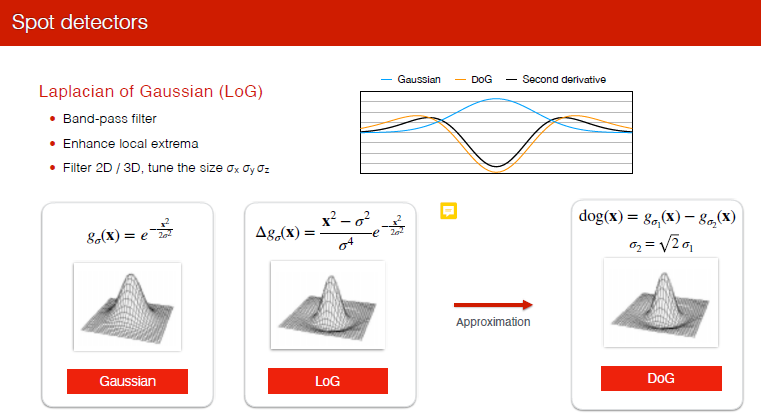

In [7]:
def DOG_fct(image, sigma, plot=False):
    DOG_image = skimage.filters.gaussian(image, sigma=sigma, preserve_range=True)-skimage.filters.gaussian(image, sigma=sigma*np.sqrt(2), preserve_range=True)
        
    if plot==True:
        plot_image(DOG_image, "DOG filtering")
    
    else:
        return DOG_image

### Visualization

In [8]:
interact(DOG_fct, image=fixed(im[0]), sigma=(1, 10 ,1), plot=fixed(True))

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), Output()), _dom_classes=('widget…

<function __main__.DOG_fct(image, sigma, plot=False)>

### <span style="color:blue">Question 3</span>

We are searching to distinguish the particles as good as possible from the background and Nucleus. The value that best results have is sigma=2.
A bigger sigma results in more relevance of the nucleus, a smaller has too much noise.

In [9]:
sigma = 2

### <span style="color:blue">Question 4: local maxima</span>

In [10]:
from skimage.color import gray2rgb

def detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False):
    detected_spots = skimage.feature.peak_local_max(DOG_image, min_distance=1, threshold_abs=threshold)
    
    if plot==True:
        image_RGB = gray2rgb(original_image)
        for spot in detected_spots:
            rr, cc = circle_perimeter(spot[0], spot[1], size, shape=(original_image.shape[0], original_image.shape[1]))
            image_RGB[rr, cc, :] = (255, 0, 0)
        plot_image_RGB(image_RGB, "Spot detection")
    else:
        return detected_spots

### Visualization

In [11]:
from ipywidgets import widgets

DOG_image = DOG_fct(im[0], sigma)
interact(detect_local_maxima, DOG_image=fixed(DOG_image), threshold=(1,20,1), original_image=fixed(im[0]), plot=fixed(True))

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

<function __main__.detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)>

### <span style="color:blue">Question 5</span>
The best threshold is the maximum that allows us to detect all the spots without having noise detected. Unfortunately spots in the borders of the image are not detected. I imagine one solution could be zero padding the images.

This maximum is 15, as a security range I will take 13. As maybe in other images the spots are less bright.

In [12]:
threshold = 13

# Real time tracking algorithm using a nearest neighbor search
 
1. Object/spot detection on frame t
    1. Compute DoG filter of the frame t
    2. Detect the local maxima
2. Link the detections between the frames t and t - 1

In [13]:
## Initialization of global variables

velocity = 20 # maximum distance of displacement of an object between 2 consecutive frames

path_results = ""

stack_results = None # stack of images on which we are going to draw the detections and the trajectories
trajectories = []

stack_results = np.zeros((nT, im.shape[1], im.shape[2], 3), dtype=np.double)
for t in range(nT):
    stack_results[t] = gray2rgb(im[t])

## Initialization for the first frame (t=0)

### <span style="color:blue">Question 6</span>

In [14]:
current_t = 0

# Object/spot detection on the first frame
    # 1) Compute DOG filter of the first frame
DOG_image = DOG_fct(im[current_t], sigma)

    # 2) Detect the local maxima
detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)

nbSpots = detected_spots.shape[0]
print(str(nbSpots) + " points detected on frame t=0")

    # 3) Convert the dected_spots into Spot object and draw it on stack_results
spots = []
trajectories = []

for spot in detected_spots:
    x=spot[1]
    y=spot[0]
    t=current_t
    value=im[t,y,x]
    spot_object = Spot(x,y,t,value)
    spots.append(spot_object)
    spot_object.draw(size=3, stack_results=stack_results)

    # 4) Initialize the trajectories
    new_trajectory = Trajectory()
    new_trajectory.add(spot_object)
    trajectories.append(new_trajectory) 

print(str(len(trajectories))+" different trajectories")

29 points detected on frame t=0
29 different trajectories


## Iterative tracking algorithm

### <span style="color:blue">Question 7</span>

In [15]:
def cost_function(spot1, spot2):
    return spot1.distance(spot2)

### <span style="color:blue">Question 8</span>

In [16]:
for current_t in range(1, nT, 1): #range(start, stop (not included), step)

    # Object/spot detection on the frame current_t
        # 1) Compute DOG filter of the frame current_t
    DOG_image = DOG_fct(im[current_t], sigma)

        # 2) Detect the local maxima
    detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)
    
    nbSpots = detected_spots.shape[0]
    print(str(nbSpots) + " points detected on the frame t=" + str(current_t))    

        # 3) Convert the dected_spots into Spot object and draw it on stack_results
    spots = []

    for spot in detected_spots:
        x=spot[1]
        y=spot[0]
        t=current_t
        value=im[t,y,x]
        spot_object = Spot(x,y,t,value)
        spots.append(spot_object)
        spot_object.draw(size=3, stack_results=stack_results)

        # 4) Build the trajectory : linking of the detections between the frames current_t and current_t - 1 using a Nearest neighbor search
    for spot in spots: #spots son los puntos del momento actual.
        min_dist=np.inf
        i=-1
        trajectory_index=-1
        for trajectory in trajectories:
            i+=1
            #In this first part I will match the detections

            if(trajectory.last_spot().t == (current_t - 1)): # Check that the last spot of the current trajectories belongs to the frame current_t - 1, otherwise they can not be linked 
                if(trajectory.last_spot().matched==None): # Check that the last spot was not linked to another detection yet
                    if(cost_function(spot, trajectory.last_spot())<min_dist): # Nearest neighbor search criteria
                        min_dist= cost_function(spot, trajectory.last_spot()) #set minimal distance
                        trajectory_index=i
                        
        #In this part I will add the point to the trajectories
        if(min_dist<velocity): # Check that the distance between two detections is realistic, i.e. it does not exceed their assumed velocity 
            trajectories[trajectory_index].last_spot().matched=spot
            trajectories[trajectory_index].add(spot)
        else: # else start a new trajectory with this spot
            new_trajectory = Trajectory()
            new_trajectory.add(spot)
            trajectories.append(new_trajectory) 

29 points detected on the frame t=1
29 points detected on the frame t=2
29 points detected on the frame t=3
28 points detected on the frame t=4
28 points detected on the frame t=5
29 points detected on the frame t=6
29 points detected on the frame t=7
28 points detected on the frame t=8
28 points detected on the frame t=9
28 points detected on the frame t=10
28 points detected on the frame t=11
28 points detected on the frame t=12
28 points detected on the frame t=13
27 points detected on the frame t=14
27 points detected on the frame t=15
27 points detected on the frame t=16
27 points detected on the frame t=17
26 points detected on the frame t=18
27 points detected on the frame t=19
27 points detected on the frame t=20
26 points detected on the frame t=21
26 points detected on the frame t=22
27 points detected on the frame t=23
26 points detected on the frame t=24
26 points detected on the frame t=25
26 points detected on the frame t=26
26 points detected on the frame t=27
26 points 

## Drawing and visualization of the trajectories

In [17]:
from skimage.io import imsave
print(str(len(trajectories))+" different trajectories")

for trajectory in trajectories:
    trajectory.draw(stack_results)
    
interact(plot_trajectories, image=fixed(stack_results), index=(0,nT-1,1), title=fixed("Trajectories"))

54 different trajectories


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.plot_trajectories(image, index, title)>

### <span style="color:blue">Question 9</span>
Are you happy with the results? Otherwise you can play with the velocity parameter. Report the final value used for the velocity and justify your choice.

Speed=10

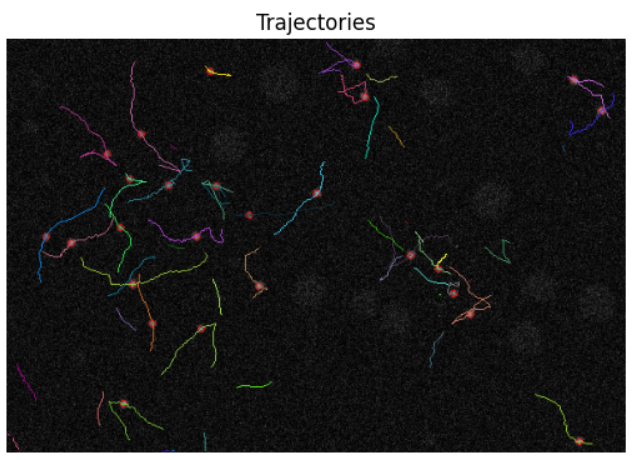

Speed=20

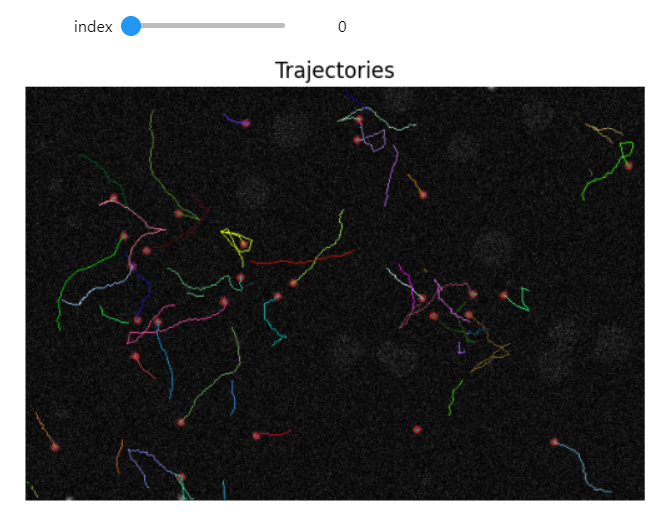

Speed=30

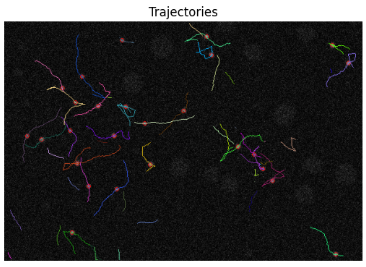

Speed=100

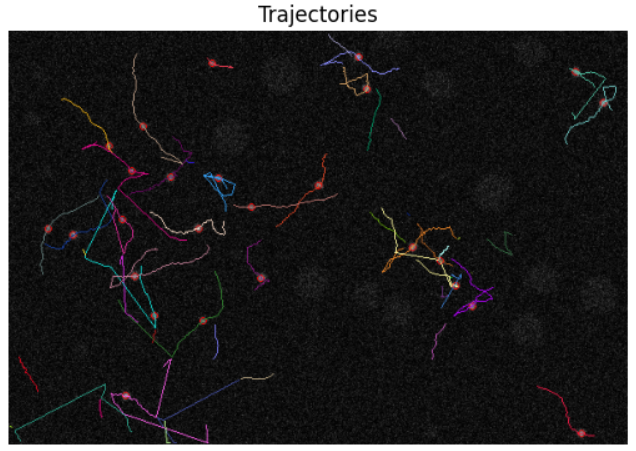

Speed 10 divides trajectories that are clearly drawn by the same particle.

Speed 100 joins paths done by seemingly different particles.

Speed 20 doesent show any clear abnormality.

54 different trajectories were identified. Meaning there is a total of 54 different particles in the sequence.

In [18]:
velocity = 20 

# Saving the results

In [19]:
imsave(path_results + "stack_results.tif", stack_results)

### <span style="color:blue">Question 10</span>
Apply your algorithm on the sequence of images "moving-particles-sample2.tif". What do you notice? Why do you think that the results are altered? Play with the parameters of your algorithm to obtain good results and report your final parameters value. Justify your answers/choices.

##Answer

The image is the same but noise was added. In the presence of high noise the particles are difficult to recognise, and "disapear" in some frames, in consequence, the trajectories are divided multiple times. We need to adjust the threshold and sigma of the filter.

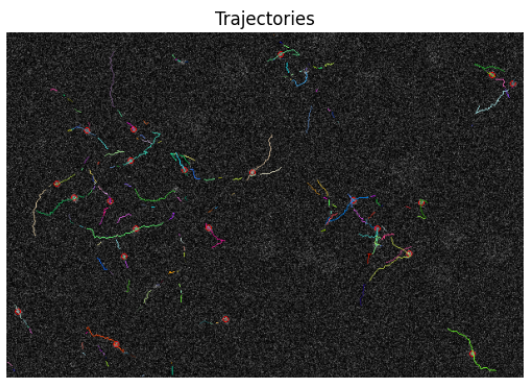

Sigma is chosen higher in order to get rid of the noise I chose sigma=3. However, this makes the particles less bright. As a consequence, the threshold has to be adapted to a lower number (6).

52 different trajectories were identified, a number similar to the previous question (54).



In [20]:
from ipywidgets import widgets
path= "./moving-particles-sample2.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

sigma=2
DOG_image = DOG_fct(im[0], sigma)
interact(detect_local_maxima, DOG_image=fixed(DOG_image), threshold=(1,20,1), original_image=fixed(im[0]), plot=fixed(True))

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

<function __main__.detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)>

In [21]:
interact(DOG_fct, image=fixed(im[0]), sigma=(1, 10 ,1), plot=fixed(True))

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), Output()), _dom_classes=('widget…

<function __main__.DOG_fct(image, sigma, plot=False)>

In [22]:
sigma=3
threshold=6

path= "./moving-particles-sample2.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

## Initialization of global variables

velocity = 20 # maximum distance of displacement of an object between 2 consecutive frames

path_results = ""

stack_results = None # stack of images on which we are going to draw the detections and the trajectories
trajectories = []

stack_results = np.zeros((nT, im.shape[1], im.shape[2], 3), dtype=np.double)
for t in range(nT):
    stack_results[t] = gray2rgb(im[t])
    

current_t = 0

# Object/spot detection on the first frame
    # 1) Compute DOG filter of the first frame
DOG_image = DOG_fct(im[current_t], sigma)

    # 2) Detect the local maxima
detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)

nbSpots = detected_spots.shape[0]
print(str(nbSpots) + " points detected on frame t=0")

    # 3) Convert the dected_spots into Spot object and draw it on stack_results
spots = []
trajectories = []

for spot in detected_spots:
    x=spot[1]
    y=spot[0]
    t=current_t
    value=im[t,y,x]
    spot_object = Spot(x,y,t,value)
    spots.append(spot_object)
    spot_object.draw(size=3, stack_results=stack_results)

    # 4) Initialize the trajectories
    new_trajectory = Trajectory()
    new_trajectory.add(spot_object)
    trajectories.append(new_trajectory) 

for current_t in range(1, nT, 1): #range(start, stop (not included), step)

    # Object/spot detection on the frame current_t
        # 1) Compute DOG filter of the frame current_t
    DOG_image = DOG_fct(im[current_t], sigma)

        # 2) Detect the local maxima
    detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)
    
    nbSpots = detected_spots.shape[0]
    print(str(nbSpots) + " points detected on the frame t=" + str(current_t))    

        # 3) Convert the dected_spots into Spot object and draw it on stack_results
    spots = []

    for spot in detected_spots:
        x=spot[1]
        y=spot[0]
        t=current_t
        value=im[t,y,x]
        spot_object = Spot(x,y,t,value)
        spots.append(spot_object)
        spot_object.draw(size=3, stack_results=stack_results)

        # 4) Build the trajectory : linking of the detections between the frames current_t and current_t - 1 using a Nearest neighbor search
    for spot in spots: #spots son los puntos del momento actual.
        min_dist=np.inf
        i=-1
        trajectory_index=-1
        for trajectory in trajectories:
            i+=1
            #In this first part I will match the detections

            if(trajectory.last_spot().t == (current_t - 1)): # Check that the last spot of the current trajectories belongs to the frame current_t - 1, otherwise they can not be linked 
                if(trajectory.last_spot().matched==None): # Check that the last spot was not linked to another detection yet
                    if(cost_function(spot, trajectory.last_spot())<min_dist): # Nearest neighbor search criteria
                        min_dist= cost_function(spot, trajectory.last_spot()) #set minimal distance
                        trajectory_index=i
                        
        #In this part I will add the point to the trajectories
        if(min_dist<velocity): # Check that the distance between two detections is realistic, i.e. it does not exceed their assumed velocity 
            trajectories[trajectory_index].last_spot().matched=spot
            trajectories[trajectory_index].add(spot)
        else: # else start a new trajectory with this spot
            new_trajectory = Trajectory()
            new_trajectory.add(spot)
            trajectories.append(new_trajectory) 

29 points detected on frame t=0
28 points detected on the frame t=1
28 points detected on the frame t=2
28 points detected on the frame t=3
28 points detected on the frame t=4
28 points detected on the frame t=5
29 points detected on the frame t=6
28 points detected on the frame t=7
28 points detected on the frame t=8
28 points detected on the frame t=9
28 points detected on the frame t=10
28 points detected on the frame t=11
28 points detected on the frame t=12
28 points detected on the frame t=13
27 points detected on the frame t=14
27 points detected on the frame t=15
27 points detected on the frame t=16
27 points detected on the frame t=17
26 points detected on the frame t=18
27 points detected on the frame t=19
27 points detected on the frame t=20
26 points detected on the frame t=21
26 points detected on the frame t=22
27 points detected on the frame t=23
26 points detected on the frame t=24
26 points detected on the frame t=25
26 points detected on the frame t=26
26 points detec

In [23]:
from skimage.io import imsave
print(str(len(trajectories))+" different trajectories")
for trajectory in trajectories:
    trajectory.draw(stack_results)
    
interact(plot_trajectories, image=fixed(stack_results), index=(0,nT-1,1), title=fixed("Trajectories"))

52 different trajectories


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.plot_trajectories(image, index, title)>

In [24]:
imsave(path_results + "stack_results_2.tif", stack_results)

### <span style="color:blue">Question 11</span>
Same question with "moving-particles-sample3.tif". Justify your answer.

This dataset contains images of a different set of particles. As we can see bellow, in frame 59 the images dont match.

This set of particles seems to moe faster that the one before. Meaning the velocity needs to be increased in order to avoid having many 1 frame long trajectories.

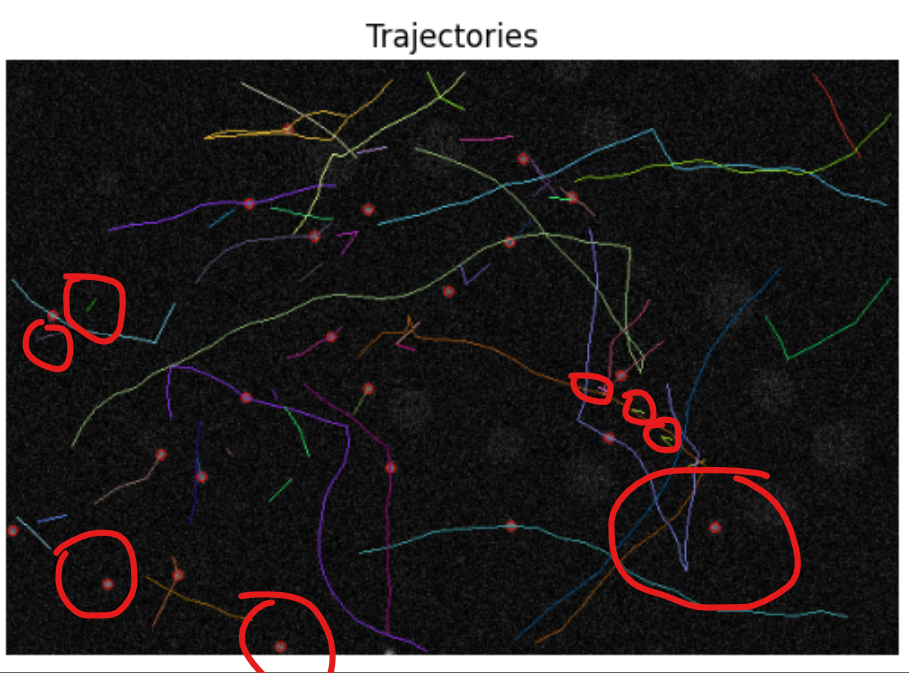

velocity=40 shows good performance. 47 different trajectories were identified.

In [25]:
from ipywidgets import widgets
path= "./moving-particles-sample3.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

frame=59

sigma=1
DOG_image = DOG_fct(im[frame], sigma)
interact(detect_local_maxima, DOG_image=fixed(DOG_image), threshold=(1,20,1), original_image=fixed(im[frame]), plot=fixed(True))

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

<function __main__.detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)>

In [26]:
from ipywidgets import widgets
path= "./moving-particles-sample2.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

frame=59

sigma=3

DOG_image = DOG_fct(im[frame], sigma)
interact(detect_local_maxima, DOG_image=fixed(DOG_image), threshold=(1,20,1), original_image=fixed(im[frame]), plot=fixed(True))

interactive(children=(IntSlider(value=10, description='threshold', max=20, min=1), IntSlider(value=3, descript…

<function __main__.detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)>

In [27]:
sigma=3
threshold=6

path= "./moving-particles-sample3.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

## Initialization of global variables

velocity = 40 # maximum distance of displacement of an object between 2 consecutive frames

path_results = ""

stack_results = None # stack of images on which we are going to draw the detections and the trajectories
trajectories = []

stack_results = np.zeros((nT, im.shape[1], im.shape[2], 3), dtype=np.double)
for t in range(nT):
    stack_results[t] = gray2rgb(im[t])
    

current_t = 0

# Object/spot detection on the first frame
    # 1) Compute DOG filter of the first frame
DOG_image = DOG_fct(im[current_t], sigma)

    # 2) Detect the local maxima
detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)

nbSpots = detected_spots.shape[0]
print(str(nbSpots) + " points detected on frame t=0")

    # 3) Convert the dected_spots into Spot object and draw it on stack_results
spots = []
trajectories = []

for spot in detected_spots:
    x=spot[1]
    y=spot[0]
    t=current_t
    value=im[t,y,x]
    spot_object = Spot(x,y,t,value)
    spots.append(spot_object)
    spot_object.draw(size=3, stack_results=stack_results)

    # 4) Initialize the trajectories
    new_trajectory = Trajectory()
    new_trajectory.add(spot_object)
    trajectories.append(new_trajectory) 

for current_t in range(1, nT, 1): #range(start, stop (not included), step)

    # Object/spot detection on the frame current_t
        # 1) Compute DOG filter of the frame current_t
    DOG_image = DOG_fct(im[current_t], sigma)

        # 2) Detect the local maxima
    detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)
    
    nbSpots = detected_spots.shape[0]
    print(str(nbSpots) + " points detected on the frame t=" + str(current_t))    

        # 3) Convert the dected_spots into Spot object and draw it on stack_results
    spots = []

    for spot in detected_spots:
        x=spot[1]
        y=spot[0]
        t=current_t
        value=im[t,y,x]
        spot_object = Spot(x,y,t,value)
        spots.append(spot_object)
        spot_object.draw(size=3, stack_results=stack_results)

        # 4) Build the trajectory : linking of the detections between the frames current_t and current_t - 1 using a Nearest neighbor search
    for spot in spots: #spots son los puntos del momento actual.
        min_dist=np.inf
        i=-1
        trajectory_index=-1
        for trajectory in trajectories:
            i+=1
            #In this first part I will match the detections

            if(trajectory.last_spot().t == (current_t - 1)): # Check that the last spot of the current trajectories belongs to the frame current_t - 1, otherwise they can not be linked 
                if(trajectory.last_spot().matched==None): # Check that the last spot was not linked to another detection yet
                    if(cost_function(spot, trajectory.last_spot())<min_dist): # Nearest neighbor search criteria
                        min_dist= cost_function(spot, trajectory.last_spot()) #set minimal distance
                        trajectory_index=i
                        
        #In this part I will add the point to the trajectories
        if(min_dist<velocity): # Check that the distance between two detections is realistic, i.e. it does not exceed their assumed velocity 
            trajectories[trajectory_index].last_spot().matched=spot
            trajectories[trajectory_index].add(spot)
        else: # else start a new trajectory with this spot
            new_trajectory = Trajectory()
            new_trajectory.add(spot)
            trajectories.append(new_trajectory) 

30 points detected on frame t=0
27 points detected on the frame t=1
28 points detected on the frame t=2
26 points detected on the frame t=3
25 points detected on the frame t=4
23 points detected on the frame t=5
23 points detected on the frame t=6
21 points detected on the frame t=7
21 points detected on the frame t=8
17 points detected on the frame t=9
17 points detected on the frame t=10
16 points detected on the frame t=11
15 points detected on the frame t=12
14 points detected on the frame t=13
14 points detected on the frame t=14
12 points detected on the frame t=15
11 points detected on the frame t=16
11 points detected on the frame t=17
11 points detected on the frame t=18
11 points detected on the frame t=19
11 points detected on the frame t=20
10 points detected on the frame t=21
10 points detected on the frame t=22
10 points detected on the frame t=23
9 points detected on the frame t=24
8 points detected on the frame t=25
8 points detected on the frame t=26
7 points detected 

In [28]:
from skimage.io import imsave
print(str(len(trajectories))+" different trajectories")
for trajectory in trajectories:
    trajectory.draw(stack_results)
    
interact(plot_trajectories, image=fixed(stack_results), index=(0,nT-1,1), title=fixed("Trajectories"))

47 different trajectories


interactive(children=(IntSlider(value=29, description='index', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.plot_trajectories(image, index, title)>

In [29]:
imsave(path_results + "stack_results_3.tif", stack_results)

# Mean square displacement analysis (MSD)

In [30]:
sigma=2
threshold=13

path= "./moving-particles-sample1.tif"
im = skimage.io.imread(path)
nT = im.shape[0]

## Initialization of global variables

velocity = 20 # maximum distance of displacement of an object between 2 consecutive frames

path_results = ""

stack_results = None # stack of images on which we are going to draw the detections and the trajectories
trajectories = []

stack_results = np.zeros((nT, im.shape[1], im.shape[2], 3), dtype=np.double)
for t in range(nT):
    stack_results[t] = gray2rgb(im[t])
    

current_t = 0

# Object/spot detection on the first frame
    # 1) Compute DOG filter of the first frame
DOG_image = DOG_fct(im[current_t], sigma)

    # 2) Detect the local maxima
detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)

nbSpots = detected_spots.shape[0]
print(str(nbSpots) + " points detected on frame t=0")

    # 3) Convert the dected_spots into Spot object and draw it on stack_results
spots = []
trajectories = []

for spot in detected_spots:
    x=spot[1]
    y=spot[0]
    t=current_t
    value=im[t,y,x]
    spot_object = Spot(x,y,t,value)
    spots.append(spot_object)
    spot_object.draw(size=3, stack_results=stack_results)

    # 4) Initialize the trajectories
    new_trajectory = Trajectory()
    new_trajectory.add(spot_object)
    trajectories.append(new_trajectory) 

for current_t in range(1, nT, 1): #range(start, stop (not included), step)

    # Object/spot detection on the frame current_t
        # 1) Compute DOG filter of the frame current_t
    DOG_image = DOG_fct(im[current_t], sigma)

        # 2) Detect the local maxima
    detected_spots = detect_local_maxima(DOG_image, threshold, size=3, original_image=None, plot=False)
    
    nbSpots = detected_spots.shape[0]
    print(str(nbSpots) + " points detected on the frame t=" + str(current_t))    

        # 3) Convert the dected_spots into Spot object and draw it on stack_results
    spots = []

    for spot in detected_spots:
        x=spot[1]
        y=spot[0]
        t=current_t
        value=im[t,y,x]
        spot_object = Spot(x,y,t,value)
        spots.append(spot_object)
        spot_object.draw(size=3, stack_results=stack_results)

        # 4) Build the trajectory : linking of the detections between the frames current_t and current_t - 1 using a Nearest neighbor search
    for spot in spots: #spots son los puntos del momento actual.
        min_dist=np.inf
        i=-1
        trajectory_index=-1
        for trajectory in trajectories:
            i+=1
            #In this first part I will match the detections

            if(trajectory.last_spot().t == (current_t - 1)): # Check that the last spot of the current trajectories belongs to the frame current_t - 1, otherwise they can not be linked 
                if(trajectory.last_spot().matched==None): # Check that the last spot was not linked to another detection yet
                    if(cost_function(spot, trajectory.last_spot())<min_dist): # Nearest neighbor search criteria
                        min_dist= cost_function(spot, trajectory.last_spot()) #set minimal distance
                        trajectory_index=i
                        
        #In this part I will add the point to the trajectories
        if(min_dist<velocity): # Check that the distance between two detections is realistic, i.e. it does not exceed their assumed velocity 
            trajectories[trajectory_index].last_spot().matched=spot
            trajectories[trajectory_index].add(spot)
        else: # else start a new trajectory with this spot
            new_trajectory = Trajectory()
            new_trajectory.add(spot)
            trajectories.append(new_trajectory) 

29 points detected on frame t=0
29 points detected on the frame t=1
29 points detected on the frame t=2
29 points detected on the frame t=3
28 points detected on the frame t=4
28 points detected on the frame t=5
29 points detected on the frame t=6
29 points detected on the frame t=7
28 points detected on the frame t=8
28 points detected on the frame t=9
28 points detected on the frame t=10
28 points detected on the frame t=11
28 points detected on the frame t=12
28 points detected on the frame t=13
27 points detected on the frame t=14
27 points detected on the frame t=15
27 points detected on the frame t=16
27 points detected on the frame t=17
26 points detected on the frame t=18
27 points detected on the frame t=19
27 points detected on the frame t=20
26 points detected on the frame t=21
26 points detected on the frame t=22
27 points detected on the frame t=23
26 points detected on the frame t=24
26 points detected on the frame t=25
26 points detected on the frame t=26
26 points detec

### <span style="color:blue">Question 12</span>
Compute the MSD for one particle (one trajectory).

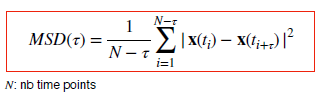

In [31]:
def compute_MSD(trajectory):
    MSD_t=[]
    for t in range(len(trajectory.list_spots)):
        sum=0
        for i in range(len(trajectory.list_spots)-t):
            sum+=(trajectory.list_spots[i].distance(trajectory.list_spots[i+t]))**2
        MSD=(1/(len(trajectory.list_spots)-t))*sum
        MSD_t.append(MSD) 
    return MSD_t

In [32]:
print(trajectories[38].list_spots[0].distance(trajectories[38].list_spots[1]))
print(np.shape(im))

3.1622776601683795
(60, 400, 600)


In [33]:
print(len(trajectories[38].list_spots))

23


### <span style="color:blue">Question 13</span>
Plot on the same figure the MSD curve of each trajectory.

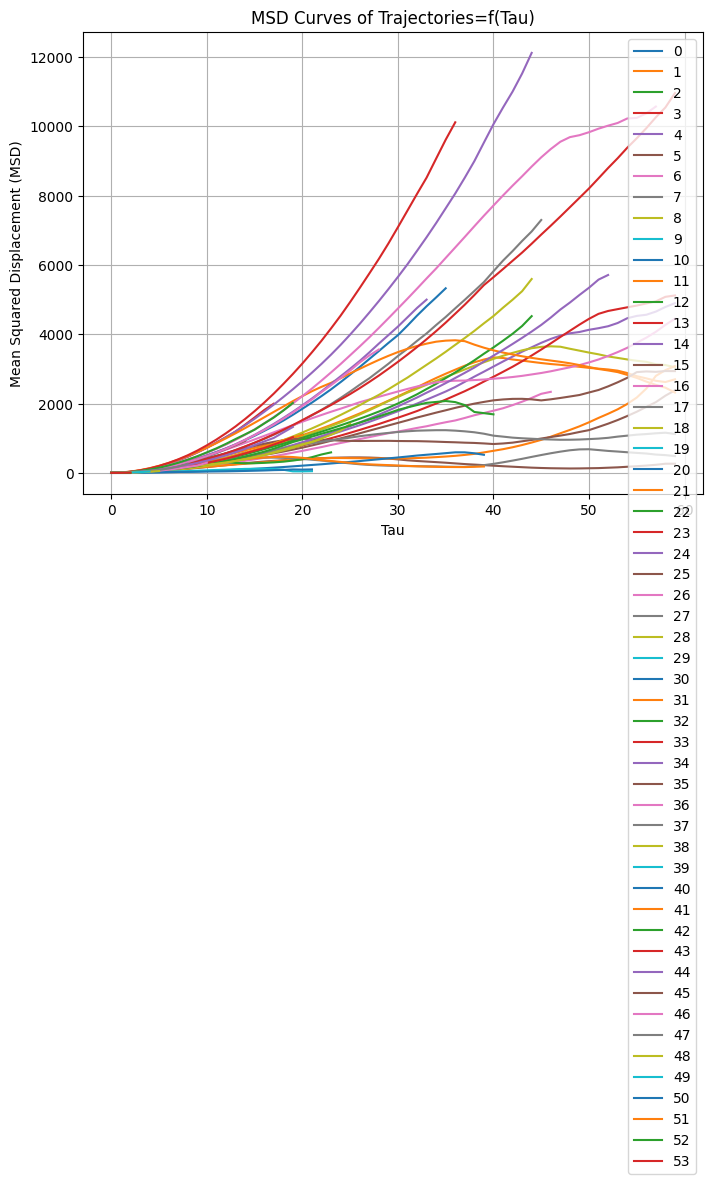

In [34]:
# Plotting
plt.figure(figsize=(8, 6))
for trajectory in trajectories:
    MSD_values = compute_MSD(trajectory)
    plt.plot(range(len(MSD_values)), MSD_values, label='{}'.format(trajectories.index(trajectory)))

plt.xlabel('Tau')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('MSD Curves of Trajectories=f(Tau)')
plt.legend()
plt.grid(True)
plt.show()

### <span style="color:blue">Question 14</span>
Compute the average MSD of all trajectories and plot the resulting curve.

In [35]:
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

In [36]:
MSD_vector=[]
for trajectory in trajectories:
    MSD_vector.append(compute_MSD(trajectory))
Mean_MSD=avgNestedLists(MSD_vector)
print(Mean_MSD)


[0.0, 5.133718922151958, 16.906007067591492, 38.07438597359485, 64.39535147415928, 98.32681214527035, 139.129469794311, 185.54379427109006, 237.90227121458926, 294.0505271757464, 356.3716670991734, 424.28784024339717, 495.01450162942035, 570.4246508784524, 644.0359050399596, 720.6189765657862, 807.3177343490062, 896.872711669434, 959.3764257587306, 1053.6483218253663, 1109.5452634675453, 1201.5550668637388, 1379.3728490954281, 1498.410206213412, 1641.8455695366356, 1759.5790313852813, 1891.5667972668323, 2012.8076763399533, 2136.047108010971, 2205.6267990090782, 2331.275560655244, 2460.370293515552, 2592.338118718888, 2722.2689978397675, 2758.695806649491, 2886.7406696530525, 2903.503643667063, 2688.894536336904, 2783.3916854884246, 2888.0005448403617, 3243.2103378103384, 3440.636173890609, 3558.125220959596, 3684.0324019607842, 3822.5728174603173, 3282.3297134238314, 3109.903273809524, 3240.030303030303, 3306.888888888889, 3368.7912457912457, 3435.3133333333335, 3505.961904761905, 356

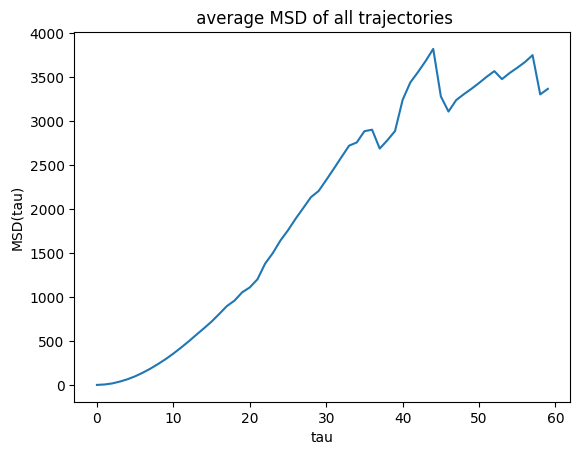

In [37]:
Mean_MSD

plt.plot(Mean_MSD)
plt.xlabel('tau')
plt.ylabel('MSD(tau)')
plt.title(' average MSD of all trajectories')
plt.show()

### <span style="color:blue">Question 15</span>
According to you, the movement of the particles correspond to directed motions (superdiffusion), Brownian motions (normal diffusion) or confined movements (subdiffusion)? Justify your answer.

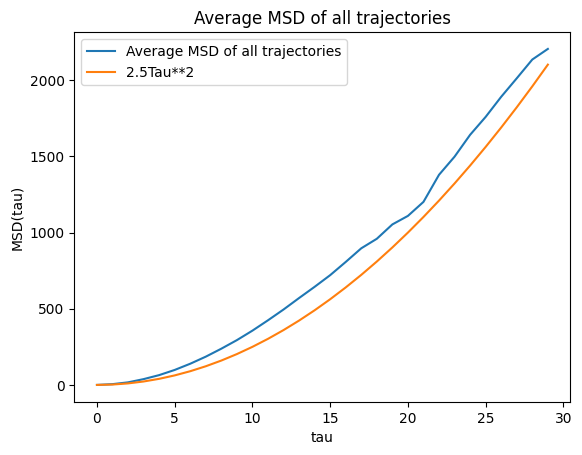

In [38]:
Mean_MSD
tau=range(len(Mean_MSD))
alpha=2
tau_alpha = [2.5*t**alpha for t in tau]


plt.plot(tau[0:30], Mean_MSD[0:30], label='Average MSD of all trajectories')
plt.plot(tau[0:30], tau_alpha[0:30], label='2.5Tau**2')
plt.xlabel('tau')
plt.ylabel('MSD(tau)')
plt.title('Average MSD of all trajectories')
plt.legend() 
plt.show()

## Answer

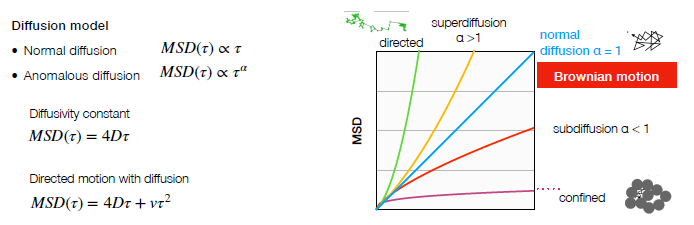

For the first values of Tau it is clear that we have a directed motion (superdiffusion).
The last values weren't analyzed as there is an abnormal behaviour, consequence of the low number of samples.